In [2]:
# Read annotated rapport sequences from the text file. 
# Format of the text file: ID-Space-Sequence in a new line for every session ID.
# Assumption: Annotated thin-slice rapport values are representative of middle of each slice.
import os
import numpy as np

parent_path = os.path.abspath('../')
thin_slice = 30
data_dir = parent_path + '/data/davos/'
file_name = 'rapport_evolution_full.txt'
smoothing_coef = 0.5

all_session_ids = []
id_to_rapp = {}

with open(data_dir + file_name, 'r') as f:
    rows = f.readlines()
    for row in rows:
        session_id = row.split()[0]
        all_session_ids.append(session_id)
        rapp = np.array(row.split(" ")[1:-1]).astype(np.float)
        id_to_rapp[session_id] = rapp

In [3]:
# Interpolate smooth cubic spline functions for every rapport sequence.
from scipy import interpolate
import pickle

pickle_file_name = 'id_to_f_full.pkl'

def get_interpolated_func(y):
    x = np.arange(thin_slice * 0.5, y.shape[0] * thin_slice + thin_slice * 0.5, thin_slice)
    f = interpolate.UnivariateSpline(x, y, s=smoothing_coef)
    return f

id_to_f = {}
for sid in all_session_ids:
    y = id_to_rapp[sid]
    id_to_f[sid] = get_interpolated_func(y)

with open(data_dir + pickle_file_name, 'wb') as f:
    pickle.dump(id_to_f, f, pickle.HIGHEST_PROTOCOL)

In [5]:
# Generate all rapport plots.
import matplotlib.pyplot as plt
import math

id_to_f = pickle.load(open(data_dir + pickle_file_name, 'rb'))
num_cols_plot = 4
num_rows_plot = math.ceil(len(all_session_ids)/num_cols_plot)

def plot_rapport(ax, y, f, sid):
    x = np.arange(thin_slice * 0.5, y.shape[0] * thin_slice + thin_slice * 0.5, thin_slice)
    xnew = np.arange(0, y.shape[0] * thin_slice)
    ynew = f(xnew)
    ax.scatter(x, y, color='navy', s=30, marker='o', label="Annotated Rapport")
    ax.plot(xnew, ynew, label='Smoothed Spline Rapport')
    ax.set_ylim(1, 7)
    ax.legend(loc='lower left')
    ax.set_xlabel('Time (in s)')
    ax.set_ylabel('Rapport')
    ax.set_title(sid)

f, axarr = plt.subplots(num_rows_plot, num_cols_plot, figsize=(8 * num_cols_plot, 6 * num_rows_plot))

for i, sid in enumerate(all_session_ids):
    row = int(i/num_cols_plot)
    col = int(i % num_cols_plot)
    y = id_to_rapp[sid]
    f = id_to_f[sid]
    plot_rapport(axarr[row, col], y, f, sid)

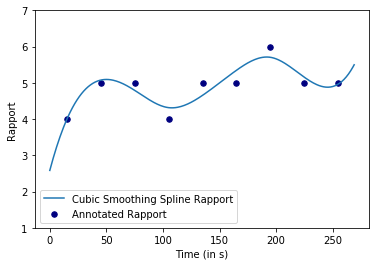

In [6]:
fig = plt.figure()

y = id_to_rapp['509969']
f = id_to_f['509969']
x = np.arange(thin_slice * 0.5, y.shape[0] * thin_slice + thin_slice * 0.5, thin_slice)
xnew = np.arange(0, y.shape[0] * thin_slice)
ynew = f(xnew)

plt.scatter(x, y, color='navy', s=30, marker='o', label="Annotated Rapport")
plt.plot(xnew, ynew, label='Cubic Smoothing Spline Rapport')
plt.ylim(1, 7)
plt.legend(loc='lower left')
plt.xlabel('Time (in s)')
plt.ylabel('Rapport')
    
fig.savefig('rapport.pdf', bbox_inches='tight')